# Functions

In [1]:
# set plot conf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

DAYS_BEFORE = 1000


In [2]:
# import necessaries
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import tushare as ts
from datetime import datetime, timedelta
import time
import math
from scipy import stats
pro = ts.pro_api()
pd.set_option('display.max_rows', 1000)



# ignore warning
import warnings
warnings.filterwarnings("ignore")

# def draw_pic(data, title_name):
#     plt.figure(figsize=(12,8))
#     plt.plot(data)
#     plt.title(title_name)
#     plt.show()


def get_option_info(key_words_list):
    temp = pro.opt_basic(
        exchange='SSE',
        call_put='C',
        fields=
        'ts_code,name,exercise_price, list_date,delist_date,maturity_date')
    for i in key_words_list:
        temp = temp[temp['name'].str.contains(i)]
    return temp


def get_opiton_code(key_words_list):
    return str(get_option_info(key_words_list)['ts_code'].values[0])


def get_date_info(option_info):
    begin_date = str(option_info['list_date'].values[0])
    end_date = str(option_info['delist_date'].values[0])
    before_begin_date = datetime.strftime(
        datetime.strptime(begin_date, '%Y%m%d') - timedelta(days=DAYS_BEFORE),
        '%Y%m%d')
    return begin_date, end_date, before_begin_date


def col_to_date_and_as_index(df, col_name):
    df[col_name] = pd.to_datetime(df[col_name])
    df.index = df[col_name]


def get_option_trade_data(option_code):
    pro = ts.pro_api()
    option_trade = pro.opt_daily(ts_code=option_code)
    col_to_date_and_as_index(option_trade, 'trade_date')
    return option_trade.sort_index()


def get_underlying_asset_trade_data():
    pro = ts.pro_api()
    data = pro.fund_daily(
        ts_code='510050.SH', start_date=before_begin_date, end_date=end_date)
    col_to_date_and_as_index(data, 'trade_date')
    return data.sort_index()


def history_volatility(price_series, periods):
    volatility = pd.DataFrame(index=price_series.index)
    volatility['log_return'] = np.log(price_series) - np.log(
        price_series).shift(1)
    volatility['std'] = price_series.rolling(window=periods).std(
        ddof=1) * np.sqrt(250) / np.sqrt(periods)
    return volatility['std']


def get_risk_free_rate_data():
    #pro = ts.pro_api()
    df = pro.shibor(
        start_date=begin_date, end_date=end_date, fields='date,3m,1y')
    df['ccr'] = np.log(1 + df['1y'] / 100)
    col_to_date_and_as_index(df, 'date')
    return df


def d1(S0, K, r, sigma, T, q=0):
    if q!=0:
        print("q=",q)
    return (np.log(S0 / K) + (r -q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


def d2(S0, K, r, sigma, T, q=0):
    if q!=0:
        print("q=",q)
    return (np.log(S0 / K) + (r -q - sigma**2 / 2) * T) / (sigma * np.sqrt(T))


def BlackScholes(type, S0, K, r, sigma, T, q=0):
    """
    S0  stock price
    K   strike price
    r   continuously compounded risk-free rate:
    sigma   volatility of the stock price per year
    T   time to maturity in trading years

    """
    if q!=0:
        print("q=",q)
    if type == "C":
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T,q)) - K * np.exp(
            -r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T,q))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(
            S0, K, r, sigma, T,q=0)) - S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T,q=0))
   

def bs_vega(option_type, S0, K, r, sigma, T):  # -dPi/dSigma
    # d1 = d1(S0, K, r, sigma, T)
    return S0 * np.sqrt(T) * ss.norm.pdf(d1(S0, K, r, sigma, T))


def implied_vol(option_type, S0, K, r, T, real_price):
    # f(x) = BSF(x) - real_price
    # x -> sigma

    def f(sigma):
        return BlackScholes(option_type, S0, K, r, sigma, T) - real_price

    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.2
    count = 0

    while abs(f(sigma)) > PRECISION:
        vega = bs_vega(option_type, S0, K, r, sigma, T)
        
        sigma = sigma - (f(sigma) / (vega)) #f/f'
        count += 1
        if count > 100: break
    return sigma


In [3]:
def construct_BS_summary_table(key_words):
    """
    key_words - list: key words of option
    volatility - Pandas series: sigma of the underlying asset trade data
    """
    global begin_date, end_date, before_begin_date, option_code, k
    
    option_info = get_option_info(key_words)
    option_code = get_opiton_code(key_words)
    begin_date, end_date, before_begin_date = get_date_info(option_info)
    option_trade = get_option_trade_data(option_code)
    underlying_asset_trade = get_underlying_asset_trade_data()
    risk_free_rate = get_risk_free_rate_data()

    k = option_info['exercise_price'].values[0]
    summary = pd.DataFrame(index=option_trade.index)
    summary['s'] = underlying_asset_trade['close']
    summary['t'] = (
        datetime.strptime(option_info['maturity_date'].values[0], "%Y%m%d") -
        underlying_asset_trade['trade_date']).dt.days / 365.0
    summary['r'] = risk_free_rate['ccr']
    #summary['sigma'] = history_volatility(underlying_asset_trade['close'], 90) 
    #summary['bs_simulate'] = BlackScholes('C', summary['s'], k, summary['r'], summary['sigma'], summary['t'])
    summary['real_price'] = option_trade['close']
    summary = summary.dropna()
    return summary, underlying_asset_trade

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
def cal_HV(summary):
    summary['HV14'] = history_volatility(underlying_asset_trade['close'], 14)
    summary['HV30'] = history_volatility(underlying_asset_trade['close'], 30)
    summary['HV30'] = history_volatility(underlying_asset_trade['close'], 30)
    #summary['HV60'] = history_volatility(underlying_asset_trade['close'], 60)
    summary['HV90'] = history_volatility(underlying_asset_trade['close'], 90)
    summary['HV120'] = history_volatility(underlying_asset_trade['close'], 120)
    summary['HV180'] = history_volatility(underlying_asset_trade['close'], 180)
    #summary['HV210'] = history_volatility(underlying_asset_trade['close'], 210)
    #summary['HV250'] = history_volatility(underlying_asset_trade['close'], 250)
    return summary


def cal_IV(summary):
    for index, rows in summary.iterrows():
        summary.loc[index, 'IV'] = implied_vol(
            'C', rows['s'], k, rows['r'], rows['t'], rows['real_price'])    
    return summary.replace([np.inf, -np.inf], np.nan).dropna()

def cal_ewma(summary):
    price_series = underlying_asset_trade['close']
    volatility = pd.DataFrame(index=price_series.index)
    volatility['log_return'] = np.log(price_series) - np.log(
        price_series).shift(1)
    volatility['u2'] = volatility['log_return']**2
    periods = {
        'EWMA1W': 5,
        'EWMA2W': 10,
        'EWMA1M': 21,
        'EWMA2M': 41,
        'EWMA3M': 62,
        'EWMA4M': 83,
        'EWMA5M': 104,
        'EWMA6M': 124,
        'EWMA9M': 186,
        'EWMA1Y': 249,
        'EWMA2Y': 497
    }
    for prd in periods.keys():
        summary[prd] = np.round(
            np.sqrt(pd.ewma(volatility['u2'], span=periods[prd], adjust=False)),
            5) * math.sqrt(252.0)
    return summary


# draft

## set option

In [5]:
summary, underlying_asset_trade = construct_BS_summary_table(['1809','2.9'])

In [6]:
def cal_bs(summary, vol):
    return BlackScholes('C', summary['s'], k, summary['r'], vol, summary['t'])

## HV

In [21]:
cal_HV(summary)

,s,t,r,real_price,ewma90,HV14,HV30,HV90,HV120,HV180
trade_date,,,,,,,,,,
2018-01-25,3.150,0.668493,0.046333,0.4153,0.141442,0.321560,0.325165,0.189670,0.181997,0.225038
2018-01-26,3.171,0.665753,0.046333,0.4295,0.140331,0.304008,0.336489,0.194275,0.186117,0.225211
2018-01-29,3.114,0.657534,0.046333,0.3770,0.147315,0.272180,0.332599,0.196150,0.188127,0.224548
2018-01-30,3.075,0.654795,0.046333,0.3403,0.149379,0.245579,0.324435,0.196689,0.189211,0.223484
2018-01-31,3.113,0.652055,0.046333,0.3709,0.150967,0.207364,0.323152,0.197945,0.191059,0.223262
2018-02-01,3.134,0.649315,0.046371,0.3845,0.149697,0.177432,0.322969,0.199563,0.192958,0.223254
2018-02-02,3.145,0.646575,0.046365,0.4044,0.147633,0.155616,0.324021,0.201579,0.194786,0.223347
2018-02-05,3.180,0.638356,0.046355,0.4356,0.148744,0.149650,0.325482,0.204646,0.196481,0.223520
2018-02-06,3.110,0.635616,0.046373,0.3907,0.159221,0.133472,0.317223,0.204915,0.196695,0.222533


## IV

In [25]:
summary

,s,t,r,real_price,ewma90,HV14,HV30,HV90,HV120,HV180
trade_date,,,,,,,,,,
2018-01-25,3.150,0.668493,0.046333,0.4153,0.141442,0.321560,0.325165,0.189670,0.181997,0.225038
2018-01-26,3.171,0.665753,0.046333,0.4295,0.140331,0.304008,0.336489,0.194275,0.186117,0.225211
2018-01-29,3.114,0.657534,0.046333,0.3770,0.147315,0.272180,0.332599,0.196150,0.188127,0.224548
2018-01-30,3.075,0.654795,0.046333,0.3403,0.149379,0.245579,0.324435,0.196689,0.189211,0.223484
2018-01-31,3.113,0.652055,0.046333,0.3709,0.150967,0.207364,0.323152,0.197945,0.191059,0.223262
2018-02-01,3.134,0.649315,0.046371,0.3845,0.149697,0.177432,0.322969,0.199563,0.192958,0.223254
2018-02-02,3.145,0.646575,0.046365,0.4044,0.147633,0.155616,0.324021,0.201579,0.194786,0.223347
2018-02-05,3.180,0.638356,0.046355,0.4356,0.148744,0.149650,0.325482,0.204646,0.196481,0.223520
2018-02-06,3.110,0.635616,0.046373,0.3907,0.159221,0.133472,0.317223,0.204915,0.196695,0.222533


In [26]:
cal_IV(summary)

,s,t,r,real_price,ewma90,HV14,HV30,HV90,HV120,HV180,IV
trade_date,,,,,,,,,,,
2018-01-25,3.150,0.668493,0.046333,0.4153,0.141442,0.321560,0.325165,0.189670,0.181997,0.225038,0.208959
2018-01-26,3.171,0.665753,0.046333,0.4295,0.140331,0.304008,0.336489,0.194275,0.186117,0.225211,0.206860
2018-01-29,3.114,0.657534,0.046333,0.3770,0.147315,0.272180,0.332599,0.196150,0.188127,0.224548,0.198264
2018-01-30,3.075,0.654795,0.046333,0.3403,0.149379,0.245579,0.324435,0.196689,0.189211,0.223484,0.189724
2018-01-31,3.113,0.652055,0.046333,0.3709,0.150967,0.207364,0.323152,0.197945,0.191059,0.223262,0.192857
2018-02-01,3.134,0.649315,0.046371,0.3845,0.149697,0.177432,0.322969,0.199563,0.192958,0.223254,0.190019
2018-02-02,3.145,0.646575,0.046365,0.4044,0.147633,0.155616,0.324021,0.201579,0.194786,0.223347,0.205881
2018-02-05,3.180,0.638356,0.046355,0.4356,0.148744,0.149650,0.325482,0.204646,0.196481,0.223520,0.213438
2018-02-06,3.110,0.635616,0.046373,0.3907,0.159221,0.133472,0.317223,0.204915,0.196695,0.222533,0.225321


## IV vs. HV

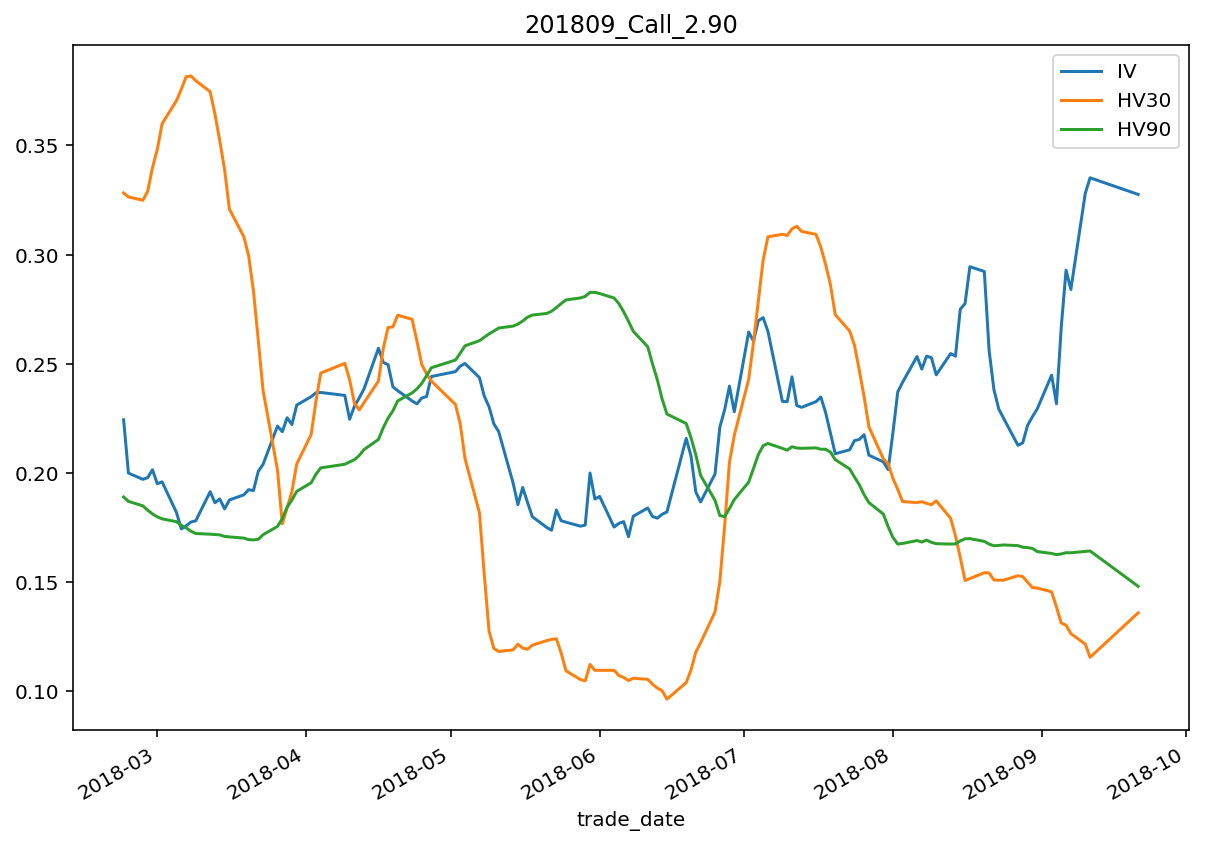

In [9]:
#plt.figure(figsize=(10,10))
plt.figure(figsize=(10, 7))

summary['IV']['20180215':].plot()
summary['HV30']['20180215':].plot()
summary['HV90']['20180215':].plot()
plt.title('201809_Call_2.90')
plt.legend()


<Figure size 1440x720 with 0 Axes>

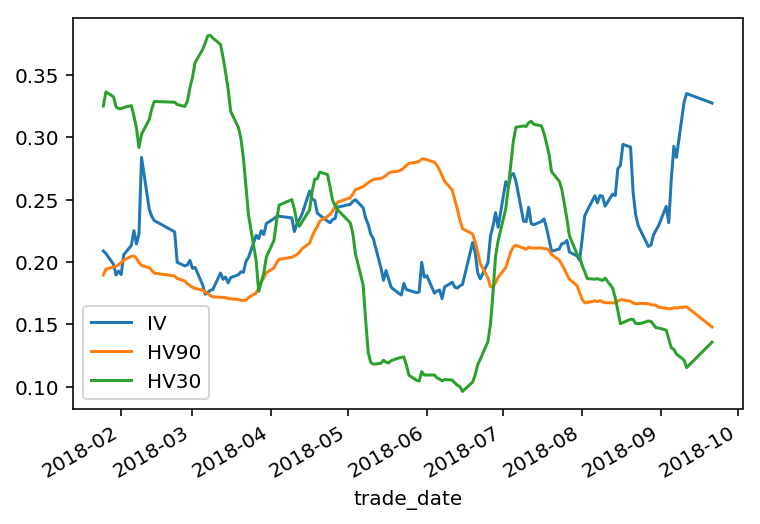

In [10]:
plt.figure(figsize=(20,10))
summary[['IV', 'HV90','HV30']]['20171201':].plot()

In [11]:
for i in ['HV30','HV90']:
    print(i)
    print(mean_absolute_percentage_error(summary['IV'],summary[i]))

HV30
36.59996499891299
HV90
21.23438627031053


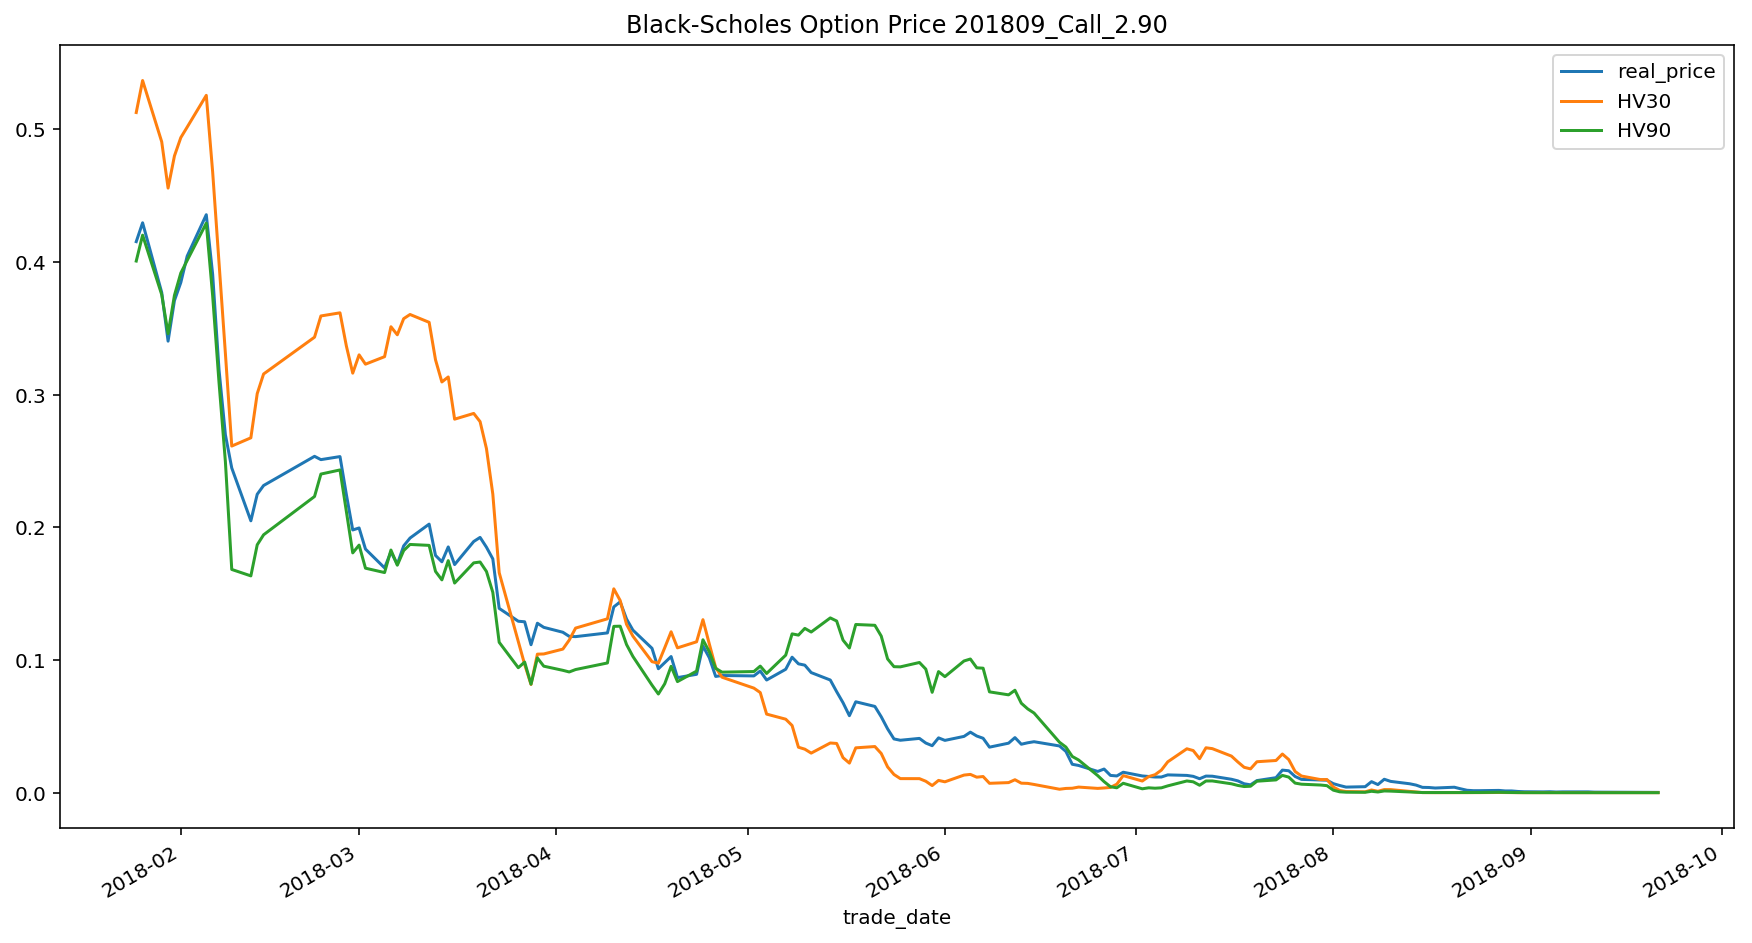

In [12]:
plt.figure(figsize=(15,8))
plt.title("Black-Scholes Option Price 201809_Call_2.90")
plt.plot(summary['real_price'])
cal_bs(summary, summary['HV30']).plot()
cal_bs(summary, summary['HV90']).plot()
plt.legend(['real_price','HV30','HV90' ])

## draw

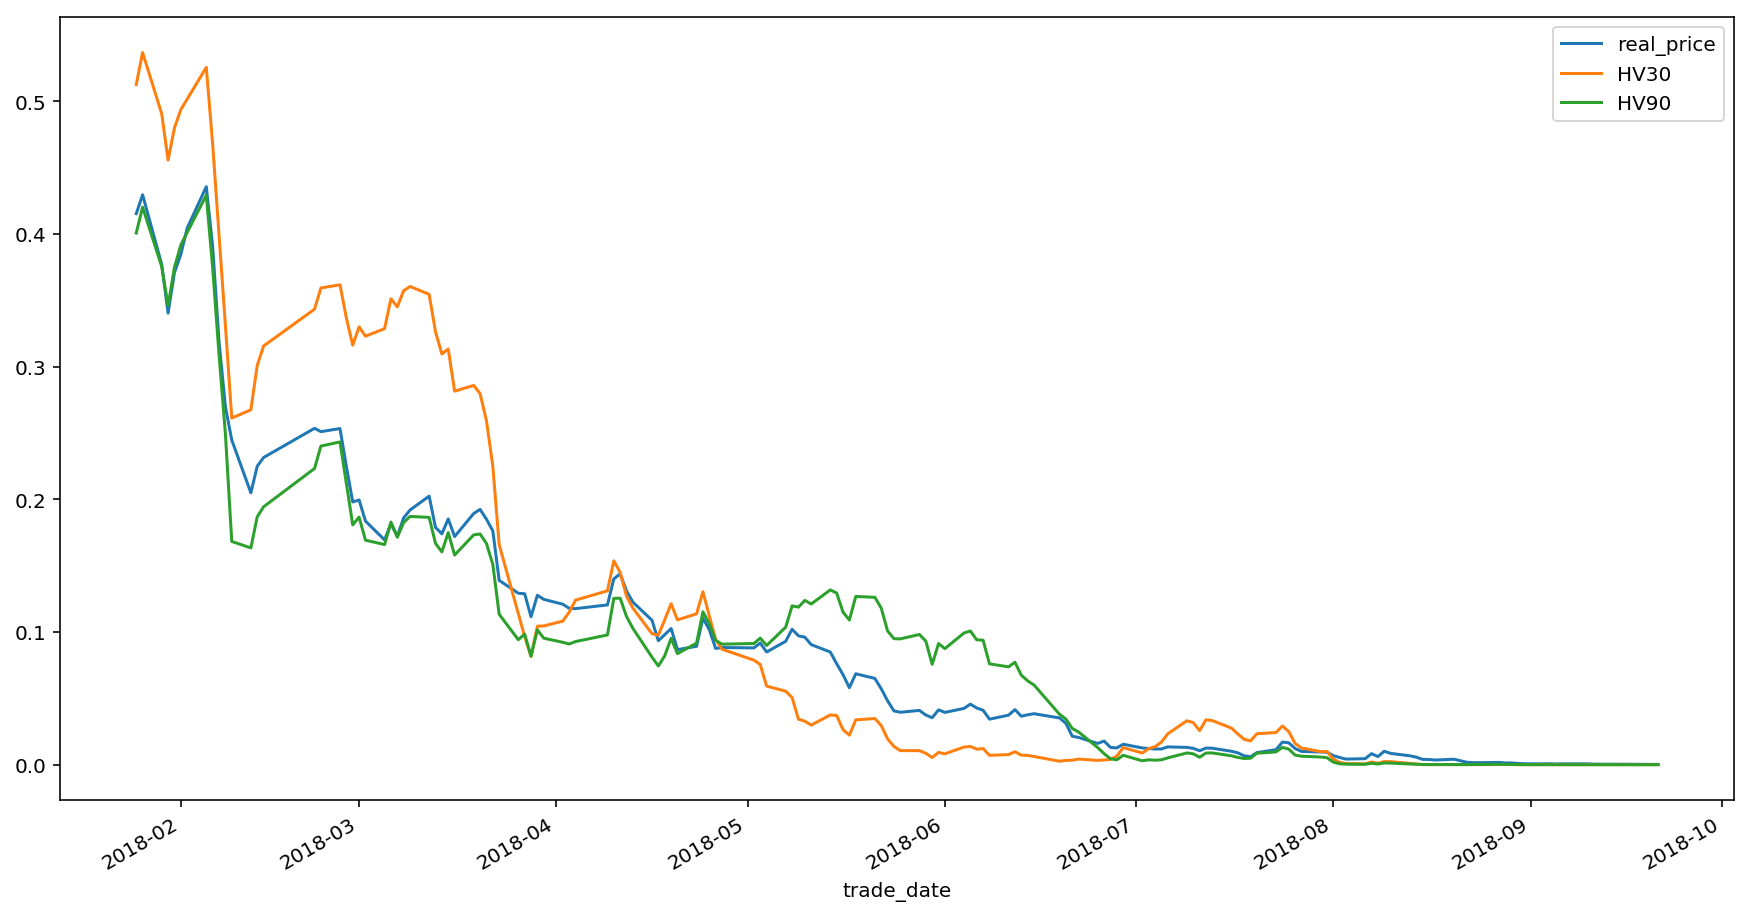

In [13]:

plt.figure(figsize=(15,8))
plt.plot(summary['real_price'])
cal_bs(summary, summary['HV30']).plot()
cal_bs(summary, summary['HV90']).plot()
plt.legend(['real_price','HV30','HV90' ])

# EWMA

## construct

In [46]:
cal_ewma(summary)

,s,t,r,real_price,HV14,HV30,HV90,HV120,HV180,IV,...,EWMA3M,EWMA2M,EWMA1Y,EWMA4M,EWMA5M,EWMA2Y,EWMA2W,EWMA1M,EWMA6M,EWMA9M
trade_date,,,,,,,,,,,,,,,,,,,,,
2018-01-25,3.150,0.668493,0.046333,0.4153,0.321560,0.325165,0.189670,0.181997,0.225038,0.208959,...,0.141442,0.139378,0.144934,0.140489,0.138902,0.225418,0.121757,0.129218,0.137314,0.136362
2018-01-26,3.171,0.665753,0.046333,0.4295,0.304008,0.336489,0.194275,0.186117,0.225211,0.206860,...,0.140331,0.137949,0.144617,0.139696,0.138267,0.225101,0.118900,0.127155,0.136838,0.136045
2018-01-29,3.114,0.657534,0.046333,0.3770,0.272180,0.332599,0.196150,0.188127,0.224548,0.198264,...,0.147315,0.148585,0.146363,0.145093,0.142553,0.225418,0.163190,0.149220,0.140489,0.138584
2018-01-30,3.075,0.654795,0.046333,0.3403,0.245579,0.324435,0.196689,0.189211,0.223484,0.189724,...,0.149379,0.151443,0.146839,0.146522,0.143982,0.225259,0.170492,0.154459,0.141759,0.139378
2018-01-31,3.113,0.652055,0.046333,0.3709,0.207364,0.323152,0.197945,0.191059,0.223262,0.192857,...,0.150967,0.153665,0.147315,0.147950,0.145093,0.225101,0.175255,0.158586,0.142712,0.140172
2018-02-01,3.134,0.649315,0.046371,0.3845,0.177432,0.322969,0.199563,0.192958,0.223254,0.190019,...,0.149697,0.151760,0.146998,0.147157,0.144458,0.224783,0.164936,0.154618,0.142236,0.139854
2018-02-02,3.145,0.646575,0.046365,0.4044,0.155616,0.324021,0.201579,0.194786,0.223347,0.205881,...,0.147633,0.148585,0.146522,0.145569,0.143188,0.224307,0.150967,0.148427,0.141283,0.139219
2018-02-05,3.180,0.638356,0.046355,0.4356,0.149650,0.325482,0.204646,0.196481,0.223520,0.213438,...,0.148744,0.150014,0.146839,0.146363,0.143982,0.224148,0.155888,0.151125,0.141918,0.139696
2018-02-06,3.110,0.635616,0.046373,0.3907,0.133472,0.317223,0.204915,0.196695,0.222533,0.225321,...,0.159221,0.165571,0.149538,0.154618,0.150649,0.224783,0.206369,0.179223,0.147633,0.143664


## vs IV

In [17]:
#plt.figure(figsize=(10,10))
summary['IV']['20180215':].plot()
summary['ewma90']['20180215':].plot()
summary['HV90']['20180215':].plot()
plt.title('201809_Call_2.90')
plt.legend()


KeyError: 'IV'

In [ ]:
summary['ewma90']['20171201':].plot()
summary['HV90']['20171201':].plot()
summary['IV']['20171201':].plot()
plt.title('201809_Call_2.90')
plt.legend()


In [ ]:
plt.figure(figsize=(15,8))
plt.plot(summary['real_price'])
cal_bs(summary, summary['HV90']).plot()
cal_bs(summary, summary['ewma90']).plot()
plt.legend(['real_price','HV90','EWMA90' ])

In [36]:
summary

,s,t,r,real_price,ewma90,HV14,HV30,HV90,HV120,HV180,IV
trade_date,,,,,,,,,,,
2018-01-25,3.150,0.668493,0.046333,0.4153,0.141442,0.321560,0.325165,0.189670,0.181997,0.225038,0.208959
2018-01-26,3.171,0.665753,0.046333,0.4295,0.140331,0.304008,0.336489,0.194275,0.186117,0.225211,0.206860
2018-01-29,3.114,0.657534,0.046333,0.3770,0.147315,0.272180,0.332599,0.196150,0.188127,0.224548,0.198264
2018-01-30,3.075,0.654795,0.046333,0.3403,0.149379,0.245579,0.324435,0.196689,0.189211,0.223484,0.189724
2018-01-31,3.113,0.652055,0.046333,0.3709,0.150967,0.207364,0.323152,0.197945,0.191059,0.223262,0.192857
2018-02-01,3.134,0.649315,0.046371,0.3845,0.149697,0.177432,0.322969,0.199563,0.192958,0.223254,0.190019
2018-02-02,3.145,0.646575,0.046365,0.4044,0.147633,0.155616,0.324021,0.201579,0.194786,0.223347,0.205881
2018-02-05,3.180,0.638356,0.046355,0.4356,0.148744,0.149650,0.325482,0.204646,0.196481,0.223520,0.213438
2018-02-06,3.110,0.635616,0.046373,0.3907,0.159221,0.133472,0.317223,0.204915,0.196695,0.222533,0.225321


In [39]:
mean_absolute_percentage_error(summary['IV'],summary['HV90'])

21.23438627031053

In [40]:
mean_absolute_percentage_error(summary['IV'],summary['ewma90'])

11.55624919611398

# summary Draft

In [48]:
summary, underlying_asset_trade = construct_BS_summary_table(['1809','2.9'])
summary = cal_HV(summary)
summary = cal_IV(summary)
summary = cal_ewma(summary)


In [49]:
summary

,s,t,r,real_price,HV14,HV30,HV90,HV120,HV180,IV,...,EWMA3M,EWMA2M,EWMA1Y,EWMA4M,EWMA5M,EWMA2Y,EWMA2W,EWMA1M,EWMA6M,EWMA9M
trade_date,,,,,,,,,,,,,,,,,,,,,
2018-01-25,3.150,0.668493,0.046333,0.4153,0.321560,0.325165,0.189670,0.181997,0.225038,0.208959,...,0.141442,0.139378,0.144934,0.140489,0.138902,0.225418,0.121757,0.129218,0.137314,0.136362
2018-01-26,3.171,0.665753,0.046333,0.4295,0.304008,0.336489,0.194275,0.186117,0.225211,0.206860,...,0.140331,0.137949,0.144617,0.139696,0.138267,0.225101,0.118900,0.127155,0.136838,0.136045
2018-01-29,3.114,0.657534,0.046333,0.3770,0.272180,0.332599,0.196150,0.188127,0.224548,0.198264,...,0.147315,0.148585,0.146363,0.145093,0.142553,0.225418,0.163190,0.149220,0.140489,0.138584
2018-01-30,3.075,0.654795,0.046333,0.3403,0.245579,0.324435,0.196689,0.189211,0.223484,0.189724,...,0.149379,0.151443,0.146839,0.146522,0.143982,0.225259,0.170492,0.154459,0.141759,0.139378
2018-01-31,3.113,0.652055,0.046333,0.3709,0.207364,0.323152,0.197945,0.191059,0.223262,0.192857,...,0.150967,0.153665,0.147315,0.147950,0.145093,0.225101,0.175255,0.158586,0.142712,0.140172
2018-02-01,3.134,0.649315,0.046371,0.3845,0.177432,0.322969,0.199563,0.192958,0.223254,0.190019,...,0.149697,0.151760,0.146998,0.147157,0.144458,0.224783,0.164936,0.154618,0.142236,0.139854
2018-02-02,3.145,0.646575,0.046365,0.4044,0.155616,0.324021,0.201579,0.194786,0.223347,0.205881,...,0.147633,0.148585,0.146522,0.145569,0.143188,0.224307,0.150967,0.148427,0.141283,0.139219
2018-02-05,3.180,0.638356,0.046355,0.4356,0.149650,0.325482,0.204646,0.196481,0.223520,0.213438,...,0.148744,0.150014,0.146839,0.146363,0.143982,0.224148,0.155888,0.151125,0.141918,0.139696
2018-02-06,3.110,0.635616,0.046373,0.3907,0.133472,0.317223,0.204915,0.196695,0.222533,0.225321,...,0.159221,0.165571,0.149538,0.154618,0.150649,0.224783,0.206369,0.179223,0.147633,0.143664


In [52]:
mean_absolute_percentage_error(summary['IV'],summary['HV30'])

36.59996499891299

In [50]:
mean_absolute_percentage_error(summary['IV'],summary['HV90'])

21.23438627031053

In [51]:
mean_absolute_percentage_error(summary['IV'],summary['EWMA3M'])

11.55624919611398

Text(0.5,1,'Black-Scholes Option Price 201809_Call_2.90')

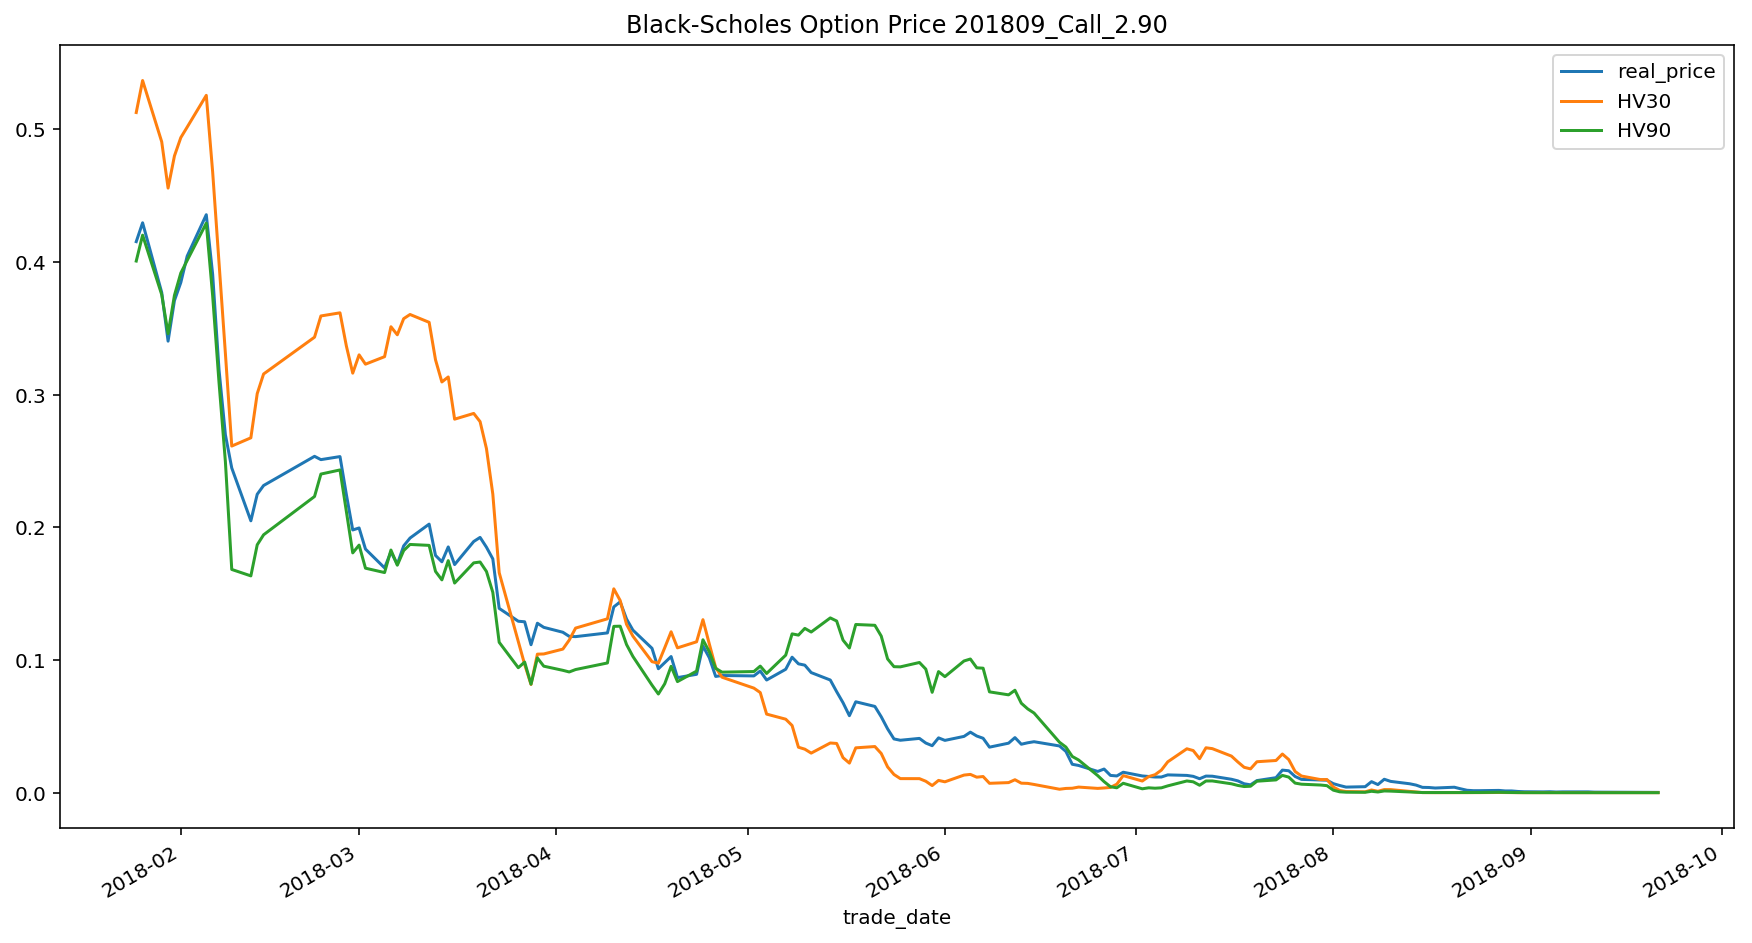

In [60]:

plt.figure(figsize=(15,8))
plt.plot(summary['real_price'])
cal_bs(summary, summary['HV30']).plot()
cal_bs(summary, summary['HV90']).plot()
plt.legend(['real_price','HV30','HV90' ])
plt.title('Black-Scholes Option Price 201809_Call_2.90')

In [74]:
summary['bs_hv30']-summary['real_price']

trade_date
2018-01-25    0.097317
2018-01-26    0.107240
2018-01-29    0.113562
2018-01-30    0.115364
2018-01-31    0.109014
2018-02-01    0.109233
2018-02-02    0.097225
2018-02-05    0.089951
2018-02-06    0.077149
2018-02-07    0.080707
2018-02-08    0.061319
2018-02-09    0.016533
2018-02-12    0.062538
2018-02-13    0.075871
2018-02-14    0.084053
2018-02-22    0.089790
2018-02-23    0.108286
2018-02-26    0.108358
2018-02-27    0.111960
2018-02-28    0.118180
2018-03-01    0.130483
2018-03-02    0.139350
2018-03-05    0.159205
2018-03-06    0.169663
2018-03-07    0.172890
2018-03-08    0.171245
2018-03-09    0.168504
2018-03-12    0.152085
2018-03-13    0.147437
2018-03-14    0.135542
2018-03-15    0.128116
2018-03-16    0.109605
2018-03-19    0.096528
2018-03-20    0.087251
2018-03-21    0.074340
2018-03-22    0.048809
2018-03-23    0.026895
2018-03-26   -0.015410
2018-03-27   -0.032153
2018-03-28   -0.029961
2018-03-29   -0.023308
2018-03-30   -0.020064
2018-04-02   -0.012695


In [71]:
summary['bs_hv30'] = cal_bs(summary, summary['HV30'])
summary[['bs_hv30','real_price']]

,bs_hv30,real_price
trade_date,,
2018-01-25,5.126166e-01,0.4153
2018-01-26,5.367404e-01,0.4295
2018-01-29,4.905624e-01,0.3770
2018-01-30,4.556644e-01,0.3403
2018-01-31,4.799142e-01,0.3709
2018-02-01,4.937333e-01,0.3845
2018-02-02,5.016248e-01,0.4044
2018-02-05,5.255515e-01,0.4356
2018-02-06,4.678492e-01,0.3907


In [76]:
mean_absolute_percentage_error(summary['bs_hv30'],summary['real_price'])

78773459769.55966

In [65]:
mean_absolute_percentage_error(cal_bs(summary, summary['HV90']),summary['real_price'])

1348614.6030109234

Text(0.5,1,'Black-Scholes Option Price 201809_Call_2.90')

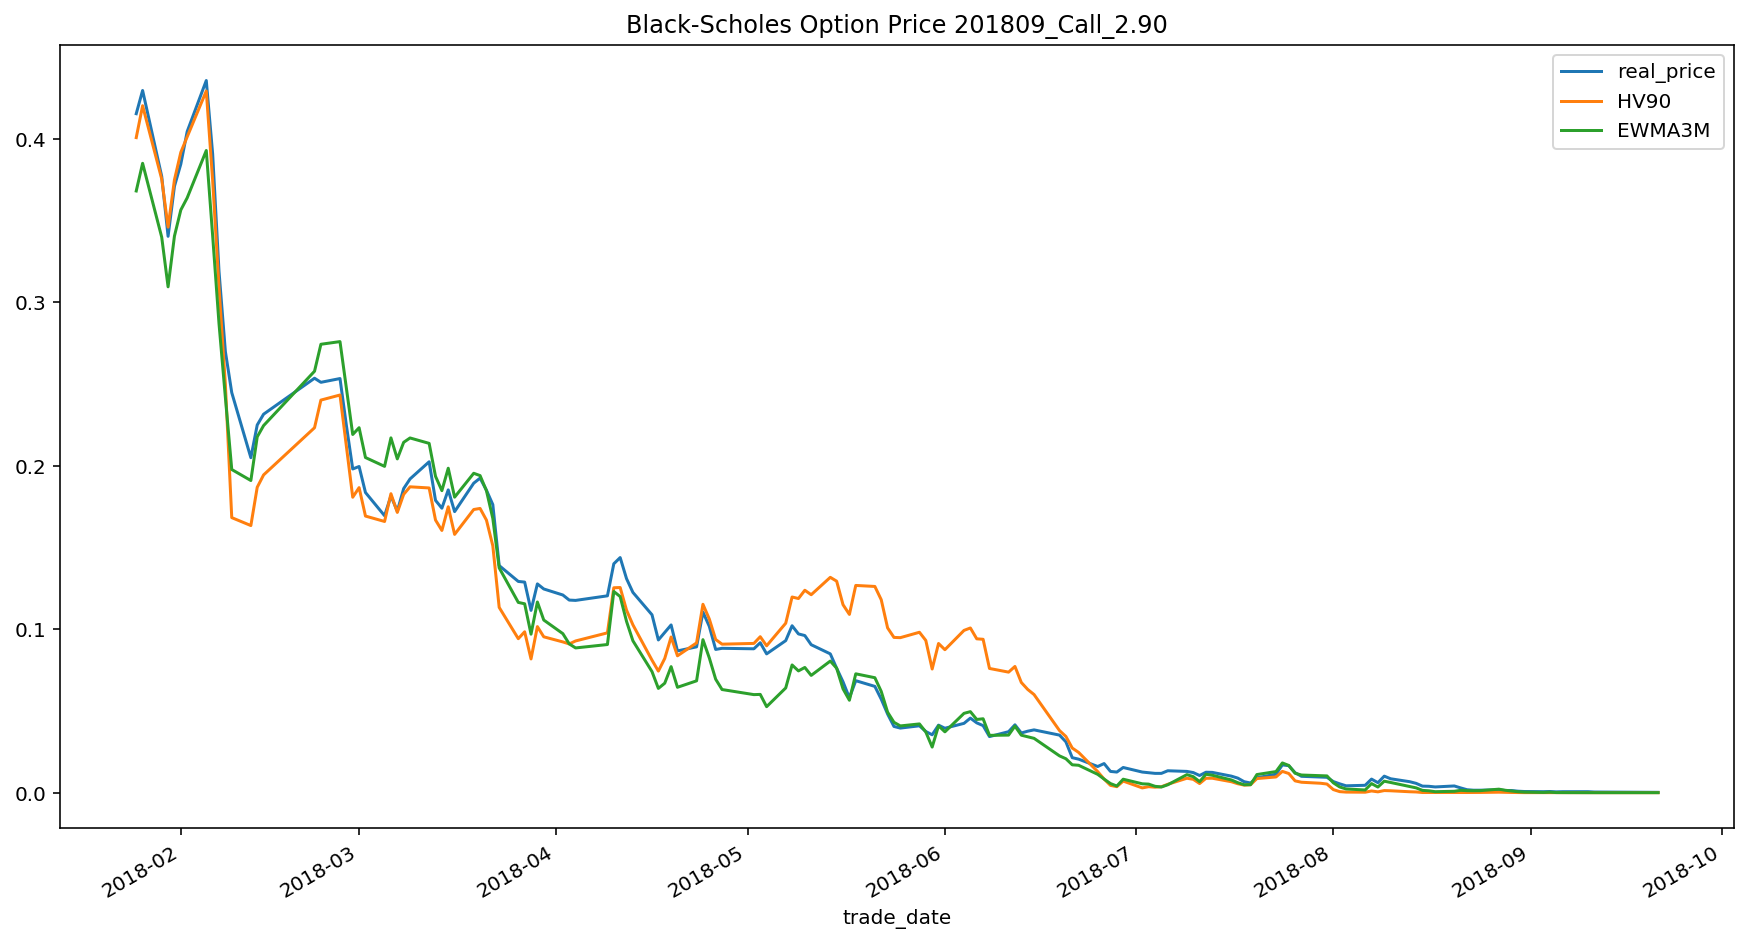

In [78]:
plt.figure(figsize=(15,8))
plt.plot(summary['real_price'])
cal_bs(summary, summary['HV90']).plot()
cal_bs(summary, summary['EWMA3M']).plot()
plt.legend(['real_price','HV90','EWMA3M' ])
plt.title('Black-Scholes Option Price 201809_Call_2.90')


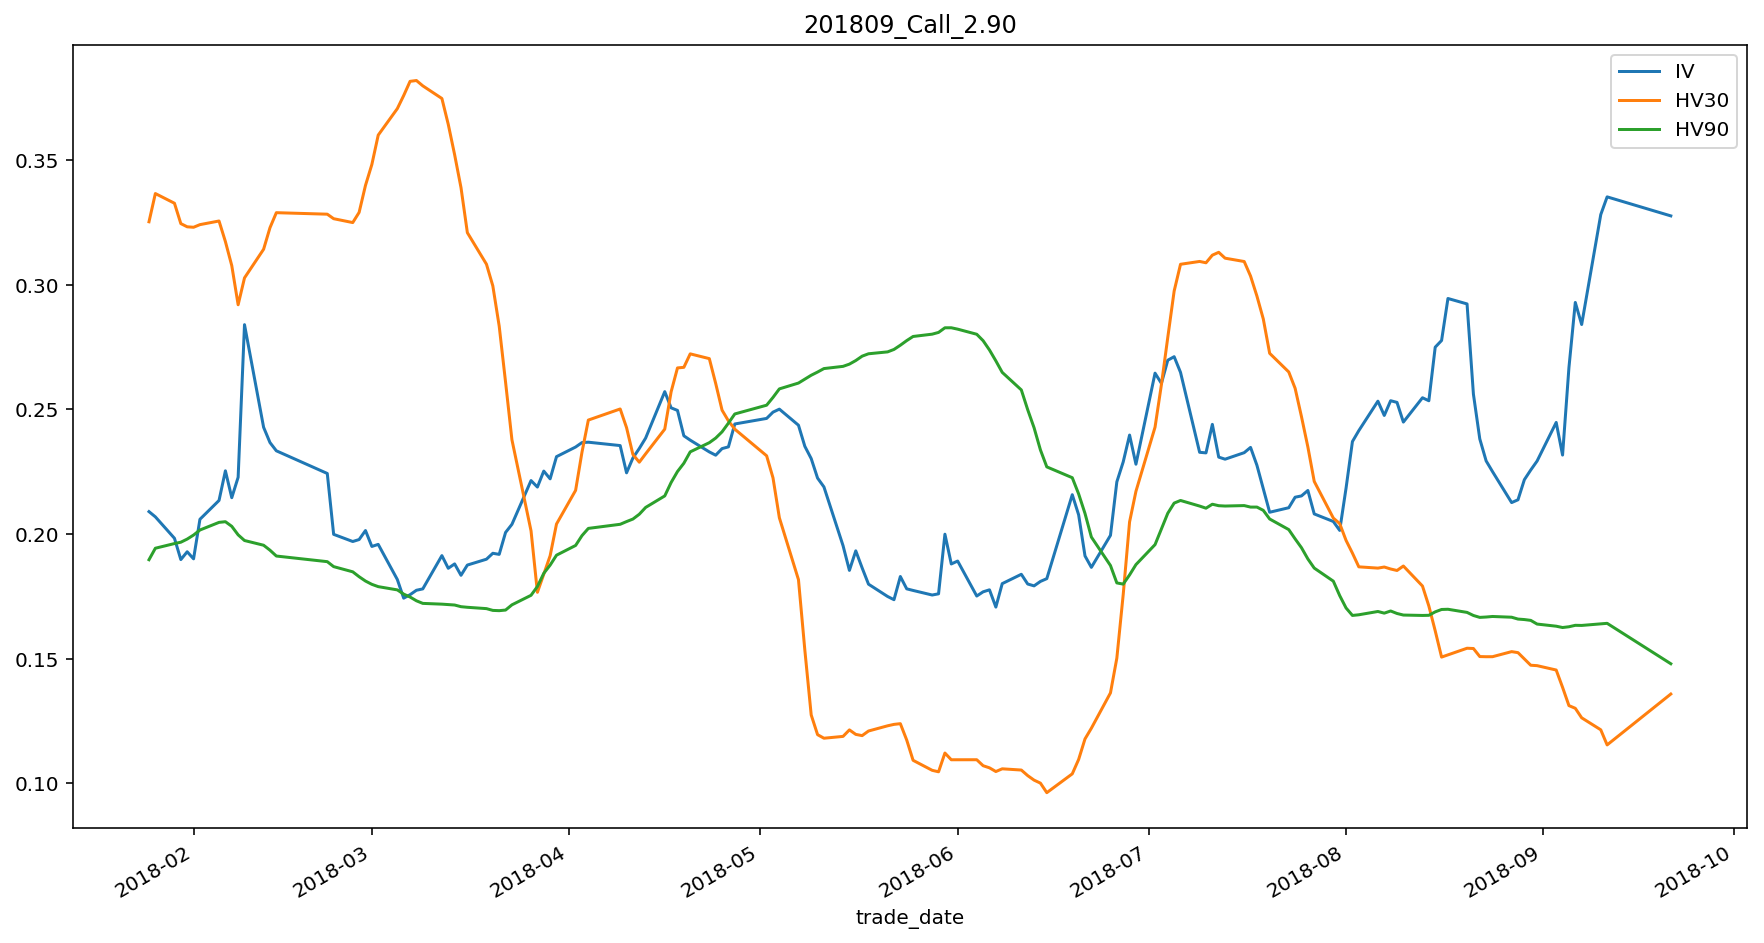

In [59]:
plt.figure(figsize=(15,8))
summary['IV'].plot()
summary['HV30'].plot()
summary['HV90'].plot()
plt.title('201809_Call_2.90')
plt.legend()

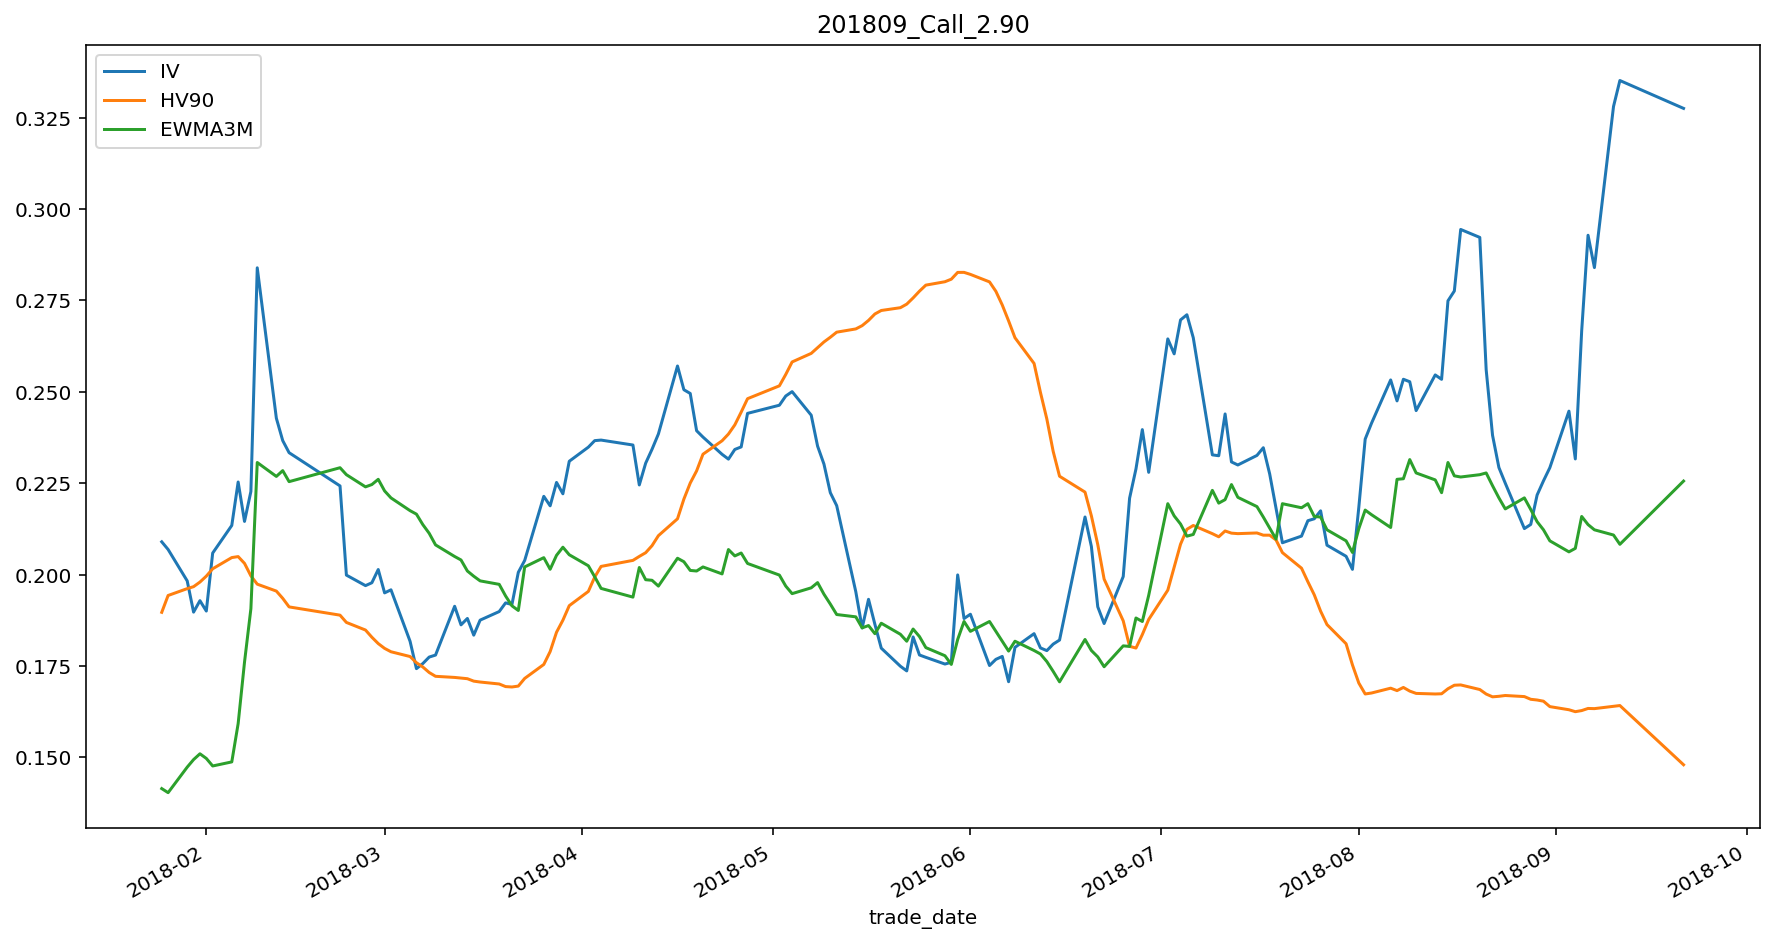

In [56]:
plt.figure(figsize=(15,8))
summary['IV'].plot()
summary['HV90'].plot()
summary['EWMA3M'].plot()
plt.title('201809_Call_2.90')
plt.legend()